In [1]:
import torch
from torch_geometric.data import DataLoader
from tqdm import tqdm
from torch import optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
plt.style.use('default')
from model import *
import numpy as np
from point_trans import PointTransformerConv
from torch_geometric.nn import EdgeConv
import torch.nn as nn

In [2]:
data = torch.load('sulc')
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
random.shuffle(data)

train_set = data[0:25]
valid_set = data[25:29]
test_set = data[29:]
print(len(train_set), len(valid_set), len(test_set))

25 4 7


In [2]:
def dice(pred, gt):
    XnY = torch.ones((len(gt))).to(device) * 32
    for i in range(len(gt)):
        if pred[i] == gt[i]:
            XnY[i] = pred[i]
    D = torch.zeros((32))
    for j in range(32):
        if (len(torch.where(pred == j)[0]) + len(torch.where(gt == j)[0])) == 0:
            D[j] = 0
        else:
            D[j] = ((2 * len(torch.where(XnY == j)[0])) / (
                        len(torch.where(pred == j)[0]) + len(torch.where(gt == j)[0])))

    dice = torch.sum(D)/32
    return dice

In [3]:
def dice_sulc(pred,gt):
    XnY = torch.ones((len(gt))).to(device)*14
    for i in range(len(gt)):
        if pred[i] == gt[i]:
            XnY[i] = pred[i]
    D = torch.zeros((14))
    for j in range(14):
        if ( len(torch.where(pred==j)[0])+len(torch.where(gt==j)[0])) == 0:
            D[j] = 0
        else:
            D[j]=((2*len(torch.where(XnY==j)[0]))/( len(torch.where(pred==j)[0])+len(torch.where(gt==j)[0])) ) 

    dice = (torch.sum(D)-D[0])/13
    return dice
    

In [4]:
!nvidia-smi

Sun Apr 10 09:23:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0  On |                    0 |
| N/A   55C    P0    54W / 300W |   1807MiB / 32475MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   55C    P0    36W / 300W |     12MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [13]:
data = torch.load('sphere6')
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
random.shuffle(data)

train_set = data[0:71]
valid_set = data[71:81]
test_set = data[81:]
print(len(train_set), len(valid_set), len(test_set))

train_loader = DataLoader(train_set, batch_size = 1, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size = 1)
test_loader = DataLoader(test_set, batch_size = 1)

71 10 20


In [14]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

In [18]:
class Net(torch.nn.Module):
    def __init__(self, in_channels,hidden_channels,out_channels, conv, aggr='max'):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.conv = conv

        if self.conv == 'edge':
            self.conv1 = EdgeConv(nn.Linear(2 * in_channels, self.hidden_channels[0]), aggr)
            self.conv2 = EdgeConv(nn.Linear(2 * (in_channels+self.hidden_channels[0]), self.hidden_channels[1]), aggr)
            self.conv3 = EdgeConv(nn.Linear(2 * (in_channels+self.hidden_channels[0]+self.hidden_channels[1]), self.hidden_channels[2]), aggr)
            self.conv4 = EdgeConv(nn.Linear(2 * (in_channels+self.hidden_channels[0]+self.hidden_channels[1]+self.hidden_channels[2]), self.hidden_channels[3]), aggr)
        else:
            self.conv1 = PointTransformerConv(in_channels, self.hidden_channels[0])
            self.conv2 = PointTransformerConv(in_channels+self.hidden_channels[0], self.hidden_channels[1])
            self.conv3 = PointTransformerConv(in_channels+self.hidden_channels[0]+self.hidden_channels[1], self.hidden_channels[2])
            self.conv4 = PointTransformerConv(in_channels+self.hidden_channels[0]+self.hidden_channels[1]+self.hidden_channels[2], self.hidden_channels[3])


        self.mlp1 = nn.Linear(in_channels+sum(self.hidden_channels), 64)
        self.mlp2 = nn.Linear(64, out_channels)

        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, data):
        x, edge_index, pos, batch = data.x[:,:self.in_channels], data.edge_index, data.x[:,:3], data.batch

        if self.conv == 'edge':
            x1 = self.conv1(x, edge_index)
        else:
            x1 = self.conv1(x, pos, edge_index)
        x1 = F.leaky_relu(x1)

        x2 = torch.cat([x, x1], 1)
        if self.conv == 'edge':
            x2 = self.conv2(x2, edge_index)
        else:
            x2 = self.conv2(x2, pos, edge_index)
        x2 = F.leaky_relu(x2)

        x3 = torch.cat([x, x1, x2], 1)
        if self.conv == 'edge':
            x3 = self.conv3(x3, edge_index)
        else:
            x3 = self.conv3(x3, pos, edge_index)
        x3 = F.leaky_relu(x3)

        x4 = torch.cat([x, x1, x2, x3], 1)
        if self.conv == 'edge':
            x4 = self.conv4(x4, edge_index)
        else:
            x4 = self.conv4(x4, pos, edge_index)
        x4 = F.leaky_relu(x4)

        out = torch.cat([x, x1, x2, x3, x4], 1)
        # m = self.mlp(out)
        # m = m.max(0).values.repeat(len(x), 1)
        #
        # out = torch.cat([out, m], 1)
        out = self.dropout(out)
        out = self.mlp1(out)
        out = self.mlp2(out)

        return out
model = Net(6,[256,128,64,32],32,'trans').to(device)
model.load_state_dict(torch.load('exp/sphere6/trans/best_model.pt'))

<All keys matched successfully>

In [19]:
train_set[0]

Data(edge_index=[2, 422982], x=[40962, 7], y=[40962])

In [ ]:
model.eval()
with torch.no_grad():
    test_dice = 0

    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)

        D = dice(pred, data.y)
#         D = dice_sulc(pred, data.y)

        test_dice += D
    test_dice /= len(test_set)
print(test_dice)

In [3]:
train_loss = torch.load('exp/sphere6/trans/train_loss.txt')
val_loss = torch.load('exp/sphere6/trans/valid_loss.txt')

Text(0.5, 1.0, 'edge conv - dense connection')

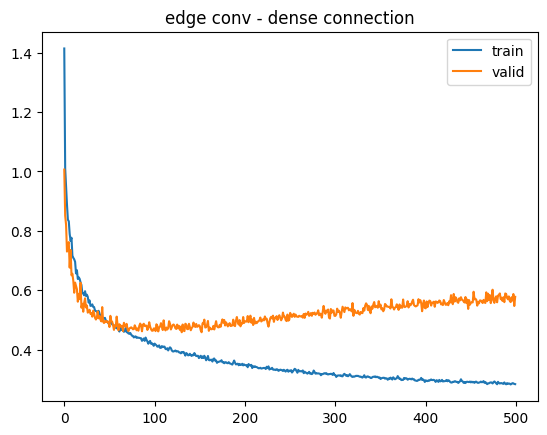

In [4]:
plt.plot(train_loss,label = 'train')
plt.plot(val_loss,label = 'valid')
# plt.ylim(0.4,0.6)
plt.legend()
plt.title('edge conv - dense connection')

In [25]:
train_loss_history = train_loss
valid_loss_history = val_loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 300, 400], gamma=0.8)

best_loss = 0.5575
for epoch in tqdm(range(100)):
    model.train()
    train_loss = 0
    valid_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)

        weight = torch.bincount(data.y) / len(data.y)
        weight = 1 / weight
        weight = weight / weight.sum()
        criterion = torch.nn.CrossEntropyLoss(weight=weight)

        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        train_loss += loss

    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            data = data.to(device)
            out = model(data)

            weight = torch.bincount(data.y) / len(data.y)
            weight = 1 / weight
            weight = weight / weight.sum()
            criterion = torch.nn.CrossEntropyLoss(weight=weight)

            loss = criterion(out, data.y)
            valid_loss += loss

    train_loss = train_loss / len(train_set)
    valid_loss = valid_loss / len(valid_set)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'exp/mindboggle/trans/best_model')

    print(f'Epoch: {epoch:03d} Train Loss: {train_loss:.4f}  Valid Loss: {valid_loss:.4f}')
torch.save(train_loss_history, 'exp/mindboggle/trans/train_loss.txt')
torch.save(valid_loss_history, 'exp/mindboggle/trans/valid_loss.txt')

  1%|          | 1/100 [01:36<2:39:30, 96.68s/it]

Epoch: 000 Train Loss: 2.9399  Valid Loss: 1.9641


  2%|▏         | 2/100 [02:54<2:28:53, 91.16s/it]

Epoch: 001 Train Loss: 1.3860  Valid Loss: 1.0993


  3%|▎         | 3/100 [04:13<2:21:02, 87.24s/it]

Epoch: 002 Train Loss: 1.0567  Valid Loss: 1.0150


  4%|▍         | 4/100 [05:31<2:15:12, 84.50s/it]

Epoch: 003 Train Loss: 0.9990  Valid Loss: 0.9322


  5%|▌         | 5/100 [06:49<2:10:54, 82.68s/it]

Epoch: 004 Train Loss: 0.9617  Valid Loss: 0.9106


  6%|▌         | 6/100 [08:08<2:07:31, 81.40s/it]

Epoch: 005 Train Loss: 0.9294  Valid Loss: 0.8884


  7%|▋         | 7/100 [09:26<2:04:50, 80.54s/it]

Epoch: 006 Train Loss: 0.9115  Valid Loss: 0.8595


  8%|▊         | 8/100 [10:45<2:02:32, 79.92s/it]

Epoch: 007 Train Loss: 0.8903  Valid Loss: 0.8483


In [9]:
!nvidia-smi

Tue Feb  8 14:18:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0  On |                    0 |
| N/A   46C    P0   131W / 300W |   5318MiB / 32475MiB |     38%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   46C    P0    99W / 300W |  25241MiB / 32478MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T